# AI Meter Reading System (Interval Capture)

This notebook mirrors the `try.py` pipeline while allowing you to run it interactively. It captures meter readings once every minute instead of continuously streaming.


## 1. Environment Setup


In [ ]:
pip install -q opencv-python easyocr numpy requests inference-sdk python-dotenv

## 2. Imports and Paths


In [2]:
import os
import time
import csv
import re
import datetime

import cv2
import numpy as np
import requests
import easyocr
from dotenv import load_dotenv
from inference_sdk import InferenceHTTPClient

from mail import send_quick_email
from twilio_try import send_reading_sms

load_dotenv()

print("Environment loaded. Using working directory:", os.getcwd())


Environment loaded. Using working directory: e:\PythonML\AI Meter Reading System


## 3. Configuration


In [3]:
# Paths
SCRIPT_DIR = os.path.dirname(os.path.abspath("try.py"))
RESULTS_DIR = os.path.join(SCRIPT_DIR, "meter_results")
DEBUG_DIR = os.path.join(RESULTS_DIR, "debug_crops")
CSV_PATH = os.path.join(RESULTS_DIR, "readings.csv")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(DEBUG_DIR, exist_ok=True)

# Camera endpoints
CAM_IP = "http://10.121.112.183"
STREAM_URL = f"{CAM_IP}/stream"
JPG_URL = f"{CAM_IP}/jpg"
ROOT_URL = CAM_IP

# ROI configuration
ROI_EXPANSION_FACTOR = 0.3
MIN_ROI_WIDTH = 200
MIN_ROI_HEIGHT = 100
MAX_ROI_WIDTH = 800
MAX_ROI_HEIGHT = 400

FALLBACK_ROIS = [
    (0.20, 0.60, 0.10, 0.90),
    (0.50, 0.90, 0.10, 0.90),
    (0.10, 0.50, 0.10, 0.90),
    (0.30, 0.70, 0.05, 0.95),
    (0.40, 0.80, 0.15, 0.85),
]

# Roboflow configuration
ROBOFLOW_API_KEY = "fuOy83MqlC1LtKZ25J0p"
ROBOFLOW_API_URL = "https://detect.roboflow.com"
DIGIT_DETECTION_MODEL = "number-detection-for-v9/3"
METER_DISPLAY_MODEL = "meter-display-yqxh9/1"

# Capture cadence (seconds)
CAPTURE_INTERVAL_SECONDS = 60

print(f"Results folder: {RESULTS_DIR}")
print(f"Capture interval: {CAPTURE_INTERVAL_SECONDS}s")


Results folder: e:\PythonML\AI Meter Reading System\meter_results
Capture interval: 60s


In [4]:
CLIENT = InferenceHTTPClient(api_url=ROBOFLOW_API_URL, api_key=ROBOFLOW_API_KEY)
reader = easyocr.Reader(['en'], gpu=False)

print("Roboflow client and EasyOCR reader initialized.")


Using CPU. Note: This module is much faster with a GPU.


Roboflow client and EasyOCR reader initialized.


## 4. Utility Functions


In [5]:
def should_send_email_today():
    """Allow only one email per day."""
    email_log_file = os.path.join(RESULTS_DIR, "email_sent.log")
    today = datetime.datetime.now().strftime("%Y-%m-%d")
    os.makedirs(RESULTS_DIR, exist_ok=True)

    if os.path.exists(email_log_file):
        with open(email_log_file, "r", encoding="utf-8") as handle:
            if handle.read().strip() == today:
                print(f"⏰ Email already sent today ({today})")
                return False

    with open(email_log_file, "w", encoding="utf-8") as handle:
        handle.write(today)
    print(f"📧 Will send email for {today}")
    return True


def should_send_sms_today():
    """Allow only one SMS per day."""
    sms_log_file = os.path.join(RESULTS_DIR, "sms_sent.log")
    today = datetime.datetime.now().strftime("%Y-%m-%d")
    os.makedirs(RESULTS_DIR, exist_ok=True)

    if os.path.exists(sms_log_file):
        try:
            with open(sms_log_file, "r", encoding="utf-8") as handle:
                if handle.read().strip() == today:
                    print(f"⏰ SMS already sent today ({today})")
                    return False
        except Exception:
            pass

    print(f"📩 Will send SMS for {today}")
    return True


def record_sms_sent():
    sms_log_file = os.path.join(RESULTS_DIR, "sms_sent.log")
    today = datetime.datetime.now().strftime("%Y-%m-%d")
    with open(sms_log_file, "w", encoding="utf-8") as handle:
        handle.write(today)


def format_reading(raw_reading: str) -> str:
    """Format raw OCR reading into 5-digit meter reading.
    
    If OCR returns 6 digits, treat the last digit as a decimal and drop it.
    For example: 014897 becomes 01489 kWh
    """
    if not raw_reading:
        return "00000"
    digits_only = re.sub(r"[^0-9]", "", raw_reading)
    # If we have 6 digits, drop the last one (it's the decimal)
    if len(digits_only) >= 6:
        digits_only = digits_only[:5]
    return digits_only[:5].zfill(5)


def get_previous_reading() -> float:
    """Get the previous reading from CSV to calculate units used.
    Handles both old format (3 columns) and new format (6 columns).
    """
    try:
        if not os.path.exists(CSV_PATH):
            return None
        
        with open(CSV_PATH, "r", encoding="utf-8") as handle:
            reader = csv.reader(handle)
            rows = list(reader)
            
        if len(rows) < 2:  # Only header or empty
            return None
            
        # Get the last row's reading (column index 2 in both old and new format)
        last_row = rows[-1]
        if len(last_row) >= 3:
            try:
                reading_str = last_row[2].strip()
                # Remove any units like "kWh" if present
                reading_str = re.sub(r'[^0-9.]', '', reading_str)
                return float(reading_str)
            except (ValueError, IndexError):
                return None
        return None
    except Exception as exc:
        print(f"[!] Error reading previous reading: {exc}")
        return None


def save_reading_csv(reading: str) -> dict:
    """Save reading to CSV with voltage, frequency, and units used.
    
    Returns:
        dict: Dictionary with all saved data including units_used
    """
    formatted = format_reading(reading)
    file_exists = os.path.exists(CSV_PATH)
    
    # Constants
    VOLTAGE = "220"
    FREQUENCY = "50"
    
    # Calculate units used
    try:
        current_reading = float(formatted)
    except ValueError:
        current_reading = 0.0
        
    previous_reading = get_previous_reading()
    if previous_reading is not None:
        units_used = max(0, current_reading - previous_reading)  # Ensure non-negative
    else:
        units_used = 0.0  # First reading, no previous data
    
    # Prepare row data
    row_data = [
        datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        int(time.time()),
        formatted,
        VOLTAGE,
        FREQUENCY,
        f"{units_used:.2f}",
    ]
    
    with open(CSV_PATH, "a", newline="", encoding="utf-8") as handle:
        writer = csv.writer(handle)
        if not file_exists:
            writer.writerow([
                "Timestamp", "Unix Time", "Reading (kWh)", 
                "Voltage (V)", "Frequency (Hz)", "Units Used (kWh)"
            ])
        writer.writerow(row_data)
    
    timestamp_str = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    result = {
        "reading": formatted,
        "voltage": VOLTAGE,
        "frequency": FREQUENCY,
        "units_used": f"{units_used:.2f}",
        "timestamp": timestamp_str,
        "previous_reading": previous_reading,
    }
    
    print(f"[✓] Saved to CSV: {formatted} kWh | Voltage: {VOLTAGE}V | Frequency: {FREQUENCY}Hz | Units Used: {units_used:.2f} kWh")
    return result


def save_debug_image(image, prefix="crop"):
    timestamp = int(time.time())
    filepath = os.path.join(DEBUG_DIR, f"{prefix}_{timestamp}.png")
    ok = cv2.imwrite(filepath, image)
    return filepath if ok else None

## 5. Image & Detection Helpers


In [6]:
def expand_roi(roi, frame_shape, expansion_factor=ROI_EXPANSION_FACTOR):
    x0, y0, x1, y1 = roi
    h, w = frame_shape[:2]

    width_expansion = int((x1 - x0) * expansion_factor)
    height_expansion = int((y1 - y0) * expansion_factor)

    x0_expanded = max(0, x0 - width_expansion)
    y0_expanded = max(0, y0 - height_expansion)
    x1_expanded = min(w, x1 + width_expansion)
    y1_expanded = min(h, y1 + height_expansion)

    if (x1_expanded - x0_expanded) < MIN_ROI_WIDTH:
        center_x = (x0_expanded + x1_expanded) // 2
        x0_expanded = max(0, center_x - MIN_ROI_WIDTH // 2)
        x1_expanded = min(w, center_x + MIN_ROI_WIDTH // 2)

    if (y1_expanded - y0_expanded) < MIN_ROI_HEIGHT:
        center_y = (y0_expanded + y1_expanded) // 2
        y0_expanded = max(0, center_y - MIN_ROI_HEIGHT // 2)
        y1_expanded = min(h, center_y + MIN_ROI_HEIGHT // 2)

    if (x1_expanded - x0_expanded) > MAX_ROI_WIDTH:
        center_x = (x0_expanded + x1_expanded) // 2
        x0_expanded = max(0, center_x - MAX_ROI_WIDTH // 2)
        x1_expanded = min(w, center_x + MAX_ROI_WIDTH // 2)

    if (y1_expanded - y0_expanded) > MAX_ROI_HEIGHT:
        center_y = (y0_expanded + y1_expanded) // 2
        y0_expanded = max(0, center_y - MAX_ROI_HEIGHT // 2)
        y1_expanded = min(h, center_y + MAX_ROI_HEIGHT // 2)

    return (x0_expanded, y0_expanded, x1_expanded, y1_expanded)


def get_fallback_rois(frame_shape):
    h, w = frame_shape[:2]
    rois = []
    for y0_frac, y1_frac, x0_frac, x1_frac in FALLBACK_ROIS:
        y0 = int(h * y0_frac)
        y1 = int(h * y1_frac)
        x0 = int(w * x0_frac)
        x1 = int(w * x1_frac)
        rois.append((x0, y0, x1, y1))
    return rois


def fetch_root_image():
    try:
        resp = requests.get(ROOT_URL, timeout=30)
        if b"<html" in resp.content.lower():
            match = re.search(r'<img\s+src="([^"]+)"', resp.text)
            if not match:
                return None
            img_url = match.group(1)
            if not img_url.startswith("http"):
                img_url = f"{CAM_IP.rstrip('/')}/{img_url.lstrip('/')}"
            resp = requests.get(img_url, timeout=30)
        arr = np.frombuffer(resp.content, np.uint8)
        return cv2.imdecode(arr, cv2.IMREAD_COLOR)
    except Exception as exc:
        print("[!] root fetch error:", exc)
        return None


def fetch_root_image_dir(filename="image.png"):
    img_path = os.path.join(os.getcwd(), filename)
    if not os.path.exists(img_path):
        print("[!] image not found in directory:", img_path)
        return None
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        print("[!] Failed to read image (possibly corrupted)")
    return img


def read_frame_via_jpg():
    try:
        resp = requests.get(JPG_URL, timeout=30)
        arr = np.frombuffer(resp.content, np.uint8)
        return cv2.imdecode(arr, cv2.IMREAD_COLOR)
    except Exception as exc:
        print("[!] jpg fetch error:", exc)
        return None


def preprocess(image):
    sharpen_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpen = cv2.filter2D(image, -1, sharpen_kernel)
    return cv2.convertScaleAbs(sharpen, alpha=1.5, beta=10)


def to_rgb_uint8(img):
    if img is None:
        return None
    img8 = img.astype("uint8") if img.dtype != "uint8" else img
    if len(img8.shape) == 2:
        return cv2.cvtColor(img8, cv2.COLOR_GRAY2BGR)
    return img8


def preprocess_variants(img):
    img_rgb = to_rgb_uint8(img)
    h, w = img_rgb.shape[:2]
    scale = max(1, int(1000 / max(w, h)))
    if scale > 1:
        img_rgb = cv2.resize(img_rgb, (w * scale, h * scale), interpolation=cv2.INTER_CUBIC)

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray)
    th = cv2.adaptiveThreshold(clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 10)
    th_inv = cv2.bitwise_not(th)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

    return {
        "orig_rgb": img_rgb,
        "gray": gray,
        "clahe": clahe,
        "th": th,
        "th_inv": th_inv,
        "closed": closed,
    }


In [7]:
# CORRECTED process_frame function - use this instead of the one above
def process_frame(frame):
    """Process frame to extract meter reading.
    
    Args:
        frame: Input image frame
    
    Returns:
        tuple: (reading, roi)
    """
    # Convert to grayscale and preprocess
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) if len(frame.shape) == 3 else frame
    preprocess(gray_frame)
    
    # Detect digits and create white background
    white_bg, _ = detect_digits_and_create_white_bg(gray_frame)

    # Detect display ROI
    roi = detect_display_roi_roboflow(gray_frame)
    if roi is None:
        print("[!] Roboflow detection failed, trying fallback ROIs...")
        return try_multiple_rois(frame, white_bg)

    print("[✓] Using Roboflow-detected ROI (expanded)")
    x0, y0, x1, y1 = roi
    white_bg_crop = white_bg[y0:y1, x0:x1]
    if white_bg_crop.size == 0:
        print("[!] Empty crop after ROI application, trying fallback ROIs")
        return try_multiple_rois(frame, white_bg)

    # Run OCR on the cropped region
    reading = run_ocr_pipeline(white_bg_crop, "roboflow")
    return reading, roi

# Replace the old process_frame with the corrected version
# process_frame = process_frame_corrected


In [8]:
def detect_digits_and_create_white_bg(frame):
    results = None
    try:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) if len(frame.shape) == 3 else frame
        temp_path = os.path.join(RESULTS_DIR, "temp_digit_frame.jpg")
        cv2.imwrite(temp_path, gray_frame)

        results = CLIENT.infer(temp_path, model_id=DIGIT_DETECTION_MODEL)
    finally:
        temp_file = os.path.join(RESULTS_DIR, "temp_digit_frame.jpg")
        if os.path.exists(temp_file):
            os.remove(temp_file)

    predictions = results.get("predictions", []) if results else []
    white_background = np.full_like(gray_frame, 255, dtype=np.uint8)

    for prediction in predictions:
        x = int(prediction["x"])
        y = int(prediction["y"])
        class_id = prediction["class"]
        cv2.putText(white_background, class_id, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

    return white_background, predictions


def detect_display_roi_roboflow(frame):
    crop = None
    try:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) if len(frame.shape) == 3 else frame
        temp_path = os.path.join(RESULTS_DIR, "temp_display_frame.jpg")
        cv2.imwrite(temp_path, gray_frame)

        crop = CLIENT.infer(temp_path, model_id=METER_DISPLAY_MODEL)
    finally:
        temp_file = os.path.join(RESULTS_DIR, "temp_display_frame.jpg")
        if os.path.exists(temp_file):
            os.remove(temp_file)

    predictions = crop.get("predictions", []) if crop else []
    if not predictions:
        return None

    primary = predictions[0]
    x = int(primary["x"])
    y = int(primary["y"])
    height = int(primary["height"])
    width = int(primary["width"])

    x0 = int(x - width / 2)
    x1 = int(x + width / 2)
    y0 = int(y - height / 2)
    y1 = int(y + height / 2)

    return expand_roi((x0, y0, x1, y1), frame.shape)


def digit_count(text):
    return len(re.findall(r"\d", text))


def run_ocr_pipeline(white_bg_crop, debug_name=""):
    if white_bg_crop is None or white_bg_crop.size == 0:
        return ""

    debug_path = save_debug_image(white_bg_crop, f"crop_{debug_name}")
    if debug_path:
        print(f"[i] Saved debug crop: {debug_path}")

    variants = preprocess_variants(white_bg_crop)
    ocr_results = {}

    for name, var_img in variants.items():
        try:
            out = reader.readtext(var_img, detail=1)
        except Exception as exc:
            print(f"[!] OCR error on variant {name}: {exc}")
            out = []

        texts = []
        for item in out:
            if len(item) >= 2:
                bbox, txt = item[0], item[1]
                xs = [p[0] for p in bbox]
                texts.append((sum(xs) / len(xs), txt))

        joined = ''.join(txt for _, txt in sorted(texts, key=lambda t: t[0]))
        ocr_results[name] = {"joined": joined, "items": texts}
        print(f"OCR raw ({name}): {joined} (boxes: {len(texts)})")

    best_name = None
    best_score = -1
    for name, info in ocr_results.items():
        score = digit_count(info["joined"])
        if score > best_score:
            best_score = score
            best_name = name

    if best_name is None and ocr_results:
        best_name = max(ocr_results.items(), key=lambda kv: len(kv[1]["joined"]))[0]

    if best_name is None:
        print("No OCR candidates found.")
        return ""

    best_joined = ocr_results[best_name]["joined"]
    cleaned = re.sub(r"\s+", "", best_joined)
    cleaned = re.sub(r"[^0-9.]", "", cleaned)

    print(f"Selected variant: {best_name}, raw: {repr(best_joined)}")
    print(f"Processed OCR output: {repr(cleaned)}")
    return cleaned


def try_multiple_rois(frame, white_bg):
    fallback_rois = get_fallback_rois(frame.shape)
    best_reading = ""
    best_roi = fallback_rois[0]
    best_digit_count = -1

    for i, roi in enumerate(fallback_rois):
        x0, y0, x1, y1 = roi
        white_bg_crop = white_bg[y0:y1, x0:x1]
        if white_bg_crop.size == 0:
            continue

        print(f"[i] Trying ROI {i + 1}: {roi}")
        reading = run_ocr_pipeline(white_bg_crop, f"roi_{i}")
        digit_count_val = digit_count(reading)
        if digit_count_val > best_digit_count:
            best_digit_count = digit_count_val
            best_reading = reading
            best_roi = roi
        if digit_count_val >= 4:
            break

    return best_reading, best_roi

def draw_results(frame, roi, reading):
    out = frame.copy()
    x0, y0, x1, y1 = roi
    cv2.rectangle(out, (x0, y0), (x1, y1), (255, 0, 0), 2)
    label = f"Reading: {reading if reading else '—'}"
    cv2.putText(out, label, (x0, max(0, y0 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    roi_info = f"ROI: {x1 - x0}x{y1 - y0}"
    cv2.putText(out, roi_info, (x0, y1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    return out


## 6. Capture Utilities


In [9]:
def get_frame(use_local=True, local_filename="image.png"):
    if use_local:
        frame = fetch_root_image_dir(local_filename)
        if frame is not None:
            return frame
        print("[!] Falling back to camera endpoint...")
    frame = read_frame_via_jpg()
    if frame is None:
        frame = fetch_root_image()
    return frame


def handle_notifications(reading: str, meter_data: dict = None):
    """Handle email and SMS notifications with meter data."""
    formatted = format_reading(reading)
    
    # Use provided meter_data or create minimal dict
    if meter_data is None:
        meter_data = {
            "reading": formatted,
            "voltage": "220",
            "frequency": "50",
            "units_used": "0.00",
        }

    if should_send_email_today():
        try:
            print("[i] Sending email notification…")
            send_quick_email(formatted, meter_data)
        except Exception as exc:
            print(f"[!] Email error: {exc}")

    if should_send_sms_today():
        try:
            print("[i] Sending SMS notification…")
            sid = send_reading_sms(formatted, meter_data=meter_data)
            if sid:
                record_sms_sent()
                print("[i] SMS sent successfully ✅ SID:", sid)
        except Exception as exc:
            print(f"[!] SMS error: {exc}")


## 7. Single Capture Runner


In [10]:
def capture_once(use_local=True, local_filename="image.png", display_result=True):
    frame = get_frame(use_local=use_local, local_filename=local_filename)
    if frame is None:
        print("[!] No frame available.")
        return None, None, None

    reading, roi = process_frame(frame)
    print(f"[{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Meter Reading: {reading or '—'}")
    
    meter_data = None
    if reading:
        meter_data = save_reading_csv(reading)

    display_image = None
    if roi is not None:
        display_image = draw_results(frame, roi, reading)

    if display_result and display_image is not None:
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    if reading:
        handle_notifications(reading, meter_data)

    return reading, roi, display_image


## 8. Interval Loop (1-minute cadence)


In [11]:
def run_interval_loop(capture_count=None, use_local=False, local_filename="image.png", display_result=False):
    completed = 0
    print("[i] Starting interval loop. Press Ctrl+C to stop.")
    try:
        while capture_count is None or completed < capture_count:
            loop_start = time.time()
            reading, roi, _ = capture_once(use_local=use_local, local_filename=local_filename, display_result=display_result)
            completed += 1

            elapsed = time.time() - loop_start
            wait_time = max(0, CAPTURE_INTERVAL_SECONDS - elapsed)
            if capture_count is None or completed < capture_count:
                print(f"[i] Waiting {wait_time:.1f}s before next capture…")
                time.sleep(wait_time)
    except KeyboardInterrupt:
        print("\n[i] Interval loop interrupted by user.")
    finally:
        print(f"[i] Loop finished after {completed} iteration(s). Data saved to {CSV_PATH}")


## 9. Quick Start

- Run the notebook top-to-bottom once to set up dependencies and functions.
- Use the cell below to run either a single capture or the minute-based loop.


[i] Starting interval loop. Press Ctrl+C to stop.
[!] image not found in directory: e:\PythonML\AI Meter Reading System\image.png
[!] Falling back to camera endpoint...
[✓] Using Roboflow-detected ROI (expanded)
[i] Saved debug crop: e:\PythonML\AI Meter Reading System\meter_results\debug_crops\crop_roboflow_1763011823.png
[✓] Using Roboflow-detected ROI (expanded)
[i] Saved debug crop: e:\PythonML\AI Meter Reading System\meter_results\debug_crops\crop_roboflow_1763011823.png
OCR raw (orig_rgb):  (boxes: 0)
OCR raw (orig_rgb):  (boxes: 0)
OCR raw (gray):  (boxes: 0)
OCR raw (gray):  (boxes: 0)
OCR raw (clahe):  (boxes: 0)
OCR raw (clahe):  (boxes: 0)
OCR raw (th):  (boxes: 0)
OCR raw (th):  (boxes: 0)
OCR raw (th_inv):  (boxes: 0)
OCR raw (th_inv):  (boxes: 0)
OCR raw (closed):  (boxes: 0)
Selected variant: orig_rgb, raw: ''
Processed OCR output: ''
[2025-11-13 11:00:27] Meter Reading: —
OCR raw (closed):  (boxes: 0)
Selected variant: orig_rgb, raw: ''
Processed OCR output: ''
[2025-11

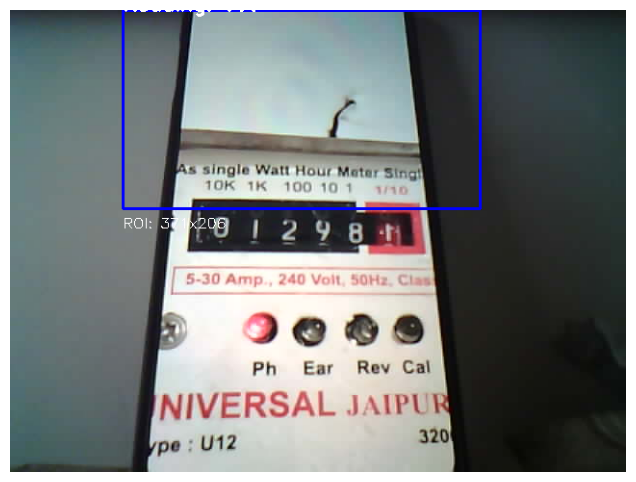

[i] Waiting 49.5s before next capture…
[!] image not found in directory: e:\PythonML\AI Meter Reading System\image.png
[!] Falling back to camera endpoint...
[!] image not found in directory: e:\PythonML\AI Meter Reading System\image.png
[!] Falling back to camera endpoint...
[!] Roboflow detection failed, trying fallback ROIs...
[i] Trying ROI 1: (64, 96, 576, 288)
[i] Saved debug crop: e:\PythonML\AI Meter Reading System\meter_results\debug_crops\crop_roi_0_1763011883.png
[!] Roboflow detection failed, trying fallback ROIs...
[i] Trying ROI 1: (64, 96, 576, 288)
[i] Saved debug crop: e:\PythonML\AI Meter Reading System\meter_results\debug_crops\crop_roi_0_1763011883.png
OCR raw (orig_rgb):  (boxes: 0)
OCR raw (orig_rgb):  (boxes: 0)
OCR raw (gray):  (boxes: 0)
OCR raw (gray):  (boxes: 0)
OCR raw (clahe):  (boxes: 0)
OCR raw (clahe):  (boxes: 0)
OCR raw (th):  (boxes: 0)
OCR raw (th):  (boxes: 0)
OCR raw (th_inv):  (boxes: 0)
OCR raw (th_inv):  (boxes: 0)
OCR raw (closed):  (boxes: 0)

OCR raw (orig_rgb): 0 1 2 9 8 (boxes: 1)
OCR raw (gray): 0 1 2 9 8 (boxes: 1)
OCR raw (gray): 0 1 2 9 8 (boxes: 1)
OCR raw (clahe): 0 1 2 9 8 (boxes: 1)
OCR raw (clahe): 0 1 2 9 8 (boxes: 1)
OCR raw (th): 0 1 2 9 8 (boxes: 1)
OCR raw (th): 0 1 2 9 8 (boxes: 1)
OCR raw (th_inv): 0 1 2 9 8 (boxes: 1)
OCR raw (th_inv): 0 1 2 9 8 (boxes: 1)
OCR raw (closed): 0 | 2 9 8 (boxes: 1)
Selected variant: orig_rgb, raw: '0 1 2 9 8'
Processed OCR output: '01298'
[2025-11-13 11:01:28] Meter Reading: 01298
[✓] Saved to CSV: 01298 kWh | Voltage: 220V | Frequency: 50Hz | Units Used: 0.00 kWh
OCR raw (closed): 0 | 2 9 8 (boxes: 1)
Selected variant: orig_rgb, raw: '0 1 2 9 8'
Processed OCR output: '01298'
[2025-11-13 11:01:28] Meter Reading: 01298
[✓] Saved to CSV: 01298 kWh | Voltage: 220V | Frequency: 50Hz | Units Used: 0.00 kWh


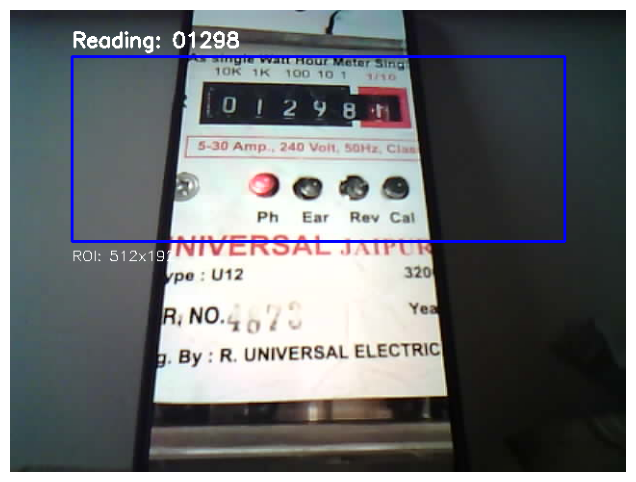

📧 Will send email for 2025-11-13
[i] Sending email notification…
[i] Preparing email...
   From: smsintegrationtest@gmail.com
   To: rathodkartik293@gmail.com
   Subject: ⚡ Meter Reading: 01298 kWh
[i] Connecting to Gmail SMTP...
[i] Starting TLS...
[i] Starting TLS...


send: 'ehlo [10.121.112.32]\r\n'
reply: b'250-smtp.gmail.com at your service, [2401:4900:5774:fe71:f9e0:110d:8938:19e8]\r\n'
reply: b'250-SIZE 35882577\r\n'
reply: b'250-8BITMIME\r\n'
reply: b'250-STARTTLS\r\n'
reply: b'250-ENHANCEDSTATUSCODES\r\n'
reply: b'250-PIPELINING\r\n'
reply: b'250-CHUNKING\r\n'
reply: b'250 SMTPUTF8\r\n'
reply: retcode (250); Msg: b'smtp.gmail.com at your service, [2401:4900:5774:fe71:f9e0:110d:8938:19e8]\nSIZE 35882577\n8BITMIME\nSTARTTLS\nENHANCEDSTATUSCODES\nPIPELINING\nCHUNKING\nSMTPUTF8'
send: 'STARTTLS\r\n'
reply: b'250-smtp.gmail.com at your service, [2401:4900:5774:fe71:f9e0:110d:8938:19e8]\r\n'
reply: b'250-SIZE 35882577\r\n'
reply: b'250-8BITMIME\r\n'
reply: b'250-STARTTLS\r\n'
reply: b'250-ENHANCEDSTATUSCODES\r\n'
reply: b'250-PIPELINING\r\n'
reply: b'250-CHUNKING\r\n'
reply: b'250 SMTPUTF8\r\n'
reply: retcode (250); Msg: b'smtp.gmail.com at your service, [2401:4900:5774:fe71:f9e0:110d:8938:19e8]\nSIZE 35882577\n8BITMIME\nSTARTTLS\nENHANCEDSTATUSCOD

[i] Logging in...


reply: b'250-smtp.gmail.com at your service, [2401:4900:5774:fe71:f9e0:110d:8938:19e8]\r\n'
reply: b'250-SIZE 35882577\r\n'
reply: b'250-8BITMIME\r\n'
reply: b'250-AUTH LOGIN PLAIN XOAUTH2 PLAIN-CLIENTTOKEN OAUTHBEARER XOAUTH\r\n'
reply: b'250-ENHANCEDSTATUSCODES\r\n'
reply: b'250-PIPELINING\r\n'
reply: b'250-CHUNKING\r\n'
reply: b'250 SMTPUTF8\r\n'
reply: retcode (250); Msg: b'smtp.gmail.com at your service, [2401:4900:5774:fe71:f9e0:110d:8938:19e8]\nSIZE 35882577\n8BITMIME\nAUTH LOGIN PLAIN XOAUTH2 PLAIN-CLIENTTOKEN OAUTHBEARER XOAUTH\nENHANCEDSTATUSCODES\nPIPELINING\nCHUNKING\nSMTPUTF8'
send: 'AUTH PLAIN AHNtc2ludGVncmF0aW9udGVzdEBnbWFpbC5jb20Ab3ZqcyB3eWZ4IGt0ZHogeG1xdA==\r\n'
reply: b'235 2.7.0 Accepted\r\n'
reply: retcode (235); Msg: b'2.7.0 Accepted'
send: 'mail FROM:<smsintegrationtest@gmail.com> size=768\r\n'
reply: b'235 2.7.0 Accepted\r\n'
reply: retcode (235); Msg: b'2.7.0 Accepted'
send: 'mail FROM:<smsintegrationtest@gmail.com> size=768\r\n'


[i] Sending email...


reply: b'250 2.1.0 OK d9443c01a7336-2985ce19a20sm8746235ad.84 - gsmtp\r\n'
reply: retcode (250); Msg: b'2.1.0 OK d9443c01a7336-2985ce19a20sm8746235ad.84 - gsmtp'
send: 'rcpt TO:<rathodkartik293@gmail.com>\r\n'
reply: b'250 2.1.5 OK d9443c01a7336-2985ce19a20sm8746235ad.84 - gsmtp\r\n'
reply: retcode (250); Msg: b'2.1.5 OK d9443c01a7336-2985ce19a20sm8746235ad.84 - gsmtp'
send: 'data\r\n'
reply: b'250 2.1.5 OK d9443c01a7336-2985ce19a20sm8746235ad.84 - gsmtp\r\n'
reply: retcode (250); Msg: b'2.1.5 OK d9443c01a7336-2985ce19a20sm8746235ad.84 - gsmtp'
send: 'data\r\n'
reply: b'354 Go ahead d9443c01a7336-2985ce19a20sm8746235ad.84 - gsmtp\r\n'
reply: retcode (354); Msg: b'Go ahead d9443c01a7336-2985ce19a20sm8746235ad.84 - gsmtp'
data: (354, b'Go ahead d9443c01a7336-2985ce19a20sm8746235ad.84 - gsmtp')
send: b'Content-Type: multipart/mixed; boundary="===============1579407336015133419=="\r\nMIME-Version: 1.0\r\nFrom: smsintegrationtest@gmail.com\r\nTo: rathodkartik293@gmail.com\r\nSubject: =?utf-

[i] Closing connection...


reply: b'221 2.0.0 closing connection d9443c01a7336-2985ce19a20sm8746235ad.84 - gsmtp\r\n'
reply: retcode (221); Msg: b'2.0.0 closing connection d9443c01a7336-2985ce19a20sm8746235ad.84 - gsmtp'


✅ Email successfully sent to rathodkartik293@gmail.com
📩 Will send SMS for 2025-11-13
[i] Sending SMS notification…
[i] SMS sent successfully ✅ SID: SM6e2ae8204c2a9e49be462205ba8e4a14
[i] Waiting 42.5s before next capture…
[i] SMS sent successfully ✅ SID: SM6e2ae8204c2a9e49be462205ba8e4a14
[i] Waiting 42.5s before next capture…
[!] image not found in directory: e:\PythonML\AI Meter Reading System\image.png
[!] Falling back to camera endpoint...
[!] image not found in directory: e:\PythonML\AI Meter Reading System\image.png
[!] Falling back to camera endpoint...
[!] Roboflow detection failed, trying fallback ROIs...
[i] Trying ROI 1: (64, 96, 576, 288)
[i] Saved debug crop: e:\PythonML\AI Meter Reading System\meter_results\debug_crops\crop_roi_0_1763011943.png
[!] Roboflow detection failed, trying fallback ROIs...
[i] Trying ROI 1: (64, 96, 576, 288)
[i] Saved debug crop: e:\PythonML\AI Meter Reading System\meter_results\debug_crops\crop_roi_0_1763011943.png
OCR raw (orig_rgb):  (boxes:

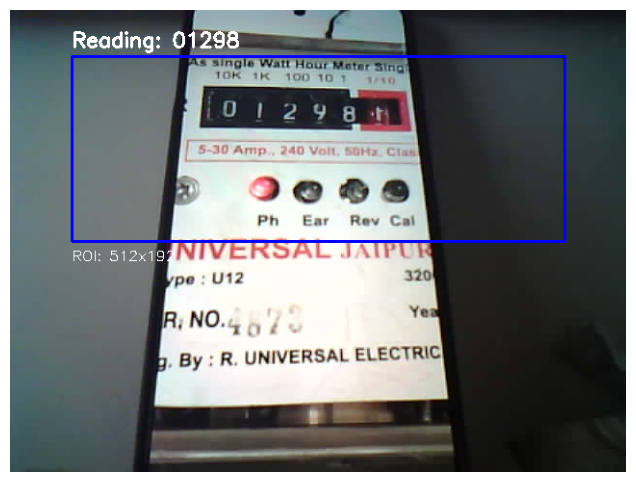

⏰ Email already sent today (2025-11-13)
⏰ SMS already sent today (2025-11-13)
[i] Loop finished after 3 iteration(s). Data saved to e:\PythonML\AI Meter Reading System\meter_results\readings.csv


In [12]:
# Example usages (uncomment the option you want to run)

# 1) Single capture using a local test image
# reading, roi, annotated = capture_once(use_local=True, local_filename="testing_dataset/meter1.png", display_result=True)

# 2) Process all test images (meter1.png to meter7.png)
# for i in range(1, 8):
#     reading, roi, annotated = capture_once(use_local=True, local_filename=f"testing_dataset/meter{i}.png", display_result=True)
#     print(f"\n--- Processed meter{i}.png ---\n")

# 3) Continuous captures every minute (press Ctrl+C to stop)
# run_interval_loop(capture_count=None, use_local=False, display_result=False)

# 4) Limited number of captures (e.g., 3 iterations) every minute
run_interval_loop(capture_count=3, use_local=True, local_filename="image.png", display_result=True)

# 5) Read testing_dataset/meter1.png every 1 minute and write to readings.csv
# run_interval_loop(capture_count=None, use_local=True, local_filename="testing_dataset/meter1.png", display_result=False)
